In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
df=pd.read_csv("data/xgboost_perfomance.csv")

In [2]:
df.shape

(244, 21)

In [3]:
working_time={
    'grid search':3927.89,
    'random params':4134.34,
    'random params in group 1':1171.77,
    'random params in group 2':855.39,
    'random params in group 3':740.36,
    'default params':61.26
}

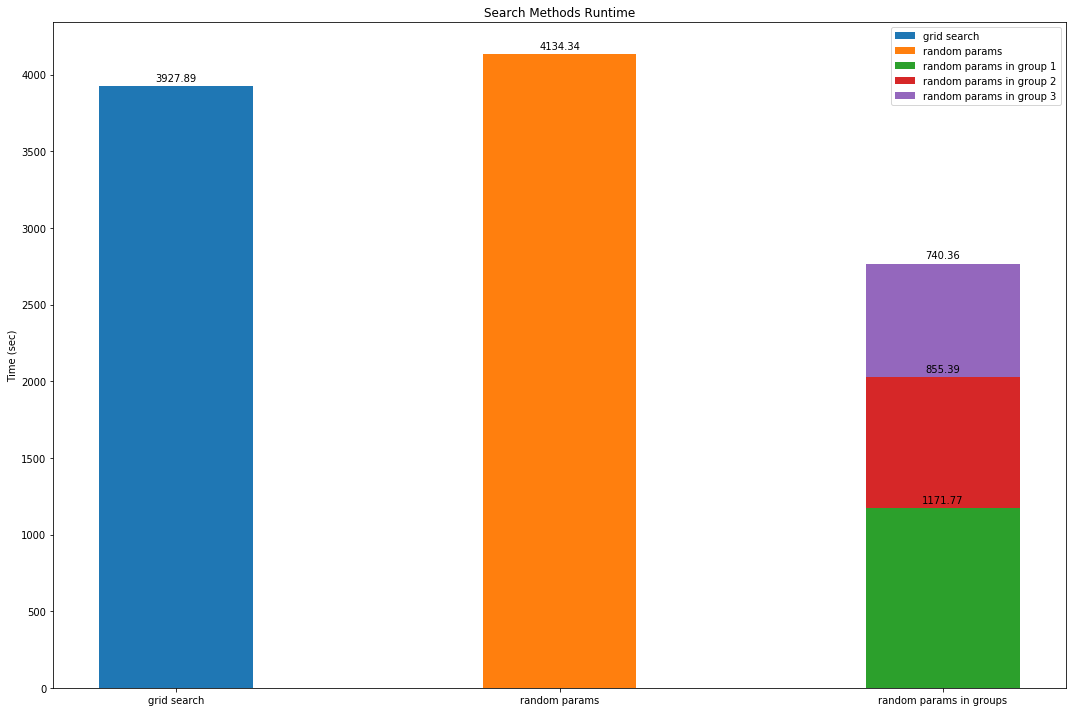

In [4]:
def autolabel(rects, add=0):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()+add
        ax.annotate('{}'.format(round(height-add,2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
x = [0,0.5,1]  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(15,10))

labels=['grid search','random params', 'random params in groups']
rects1 = ax.bar(0, working_time['grid search'], width, label='grid search')
rects2 = ax.bar(0.5, working_time['random params'], width, label='random params')

rects3_1 = ax.bar(1, working_time['random params in group 1'], width, label='random params in group 1')
rects3_2 = ax.bar(1, working_time['random params in group 2'], width,
             bottom=working_time['random params in group 1'], label='random params in group 2')
rects3_3 = ax.bar(1, working_time['random params in group 3'], width,
             bottom=working_time['random params in group 2'] + working_time['random params in group 1'], 
                  label='random params in group 3')



ax.set_ylabel('Time (sec)')
ax.set_title('Search Methods Runtime')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='best')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3_1)
autolabel(rects3_2, working_time['random params in group 1'])
autolabel(rects3_3, working_time['random params in group 1']+working_time['random params in group 2'])
fig.tight_layout()

plt.savefig("graphs/1_time_exec.jpg")
plt.show()

In [5]:
df['iter_num']=0
for experiment in df.loc[:,'experiment_name'].unique():
    df.loc[df['experiment_name']==experiment, 'iter_num']=range(1,df.loc[df['experiment_name']==experiment].shape[0]+1)

In [6]:
top5=df.loc[:,['experiment_name','params','mean_test_score']].sort_values(by='mean_test_score',ascending=False)[:5]

In [7]:
top5

,experiment_name,params,mean_test_score
231,random search for 3 group,"{'colsample_bytree': 0.7658278228089334, 'subs...",0.650531
235,random search for 3 group,"{'colsample_bytree': 0.8727909378192229, 'subs...",0.650258
240,random search for 3 group,"{'colsample_bytree': 0.8222048248547122, 'subs...",0.649804
232,random search for 3 group,"{'colsample_bytree': 0.7287339480574748, 'subs...",0.648593
233,random search for 3 group,"{'colsample_bytree': 0.5616194548633042, 'subs...",0.648514


In [8]:
for elem in top5.loc[:,'params']:
    print(elem)

{'colsample_bytree': 0.7658278228089334, 'subsample': 0.8255632339473022}
{'colsample_bytree': 0.8727909378192229, 'subsample': 0.8366073730017447}
{'colsample_bytree': 0.8222048248547122, 'subsample': 0.6590420968849985}
{'colsample_bytree': 0.7287339480574748, 'subsample': 0.7637625609371669}
{'colsample_bytree': 0.5616194548633042, 'subsample': 0.7736992256255635}


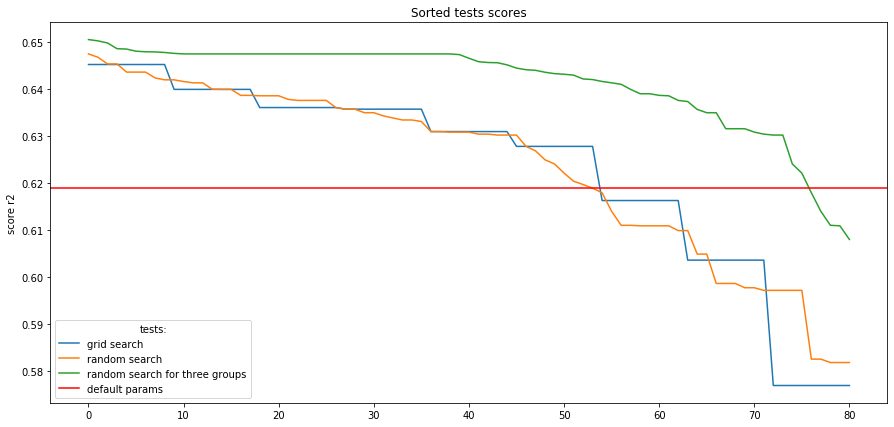

In [9]:
#comparison

name1='grid search'
data1=df.loc[df['experiment_name']==name1, 'mean_test_score'].sort_values(ascending=False)

name2='random search'
data2=df.loc[df['experiment_name']==name2, 'mean_test_score'].sort_values(ascending=False)
name3_1='random search for 1 group'
data3_1=df.loc[df['experiment_name']==name3_1, 'mean_test_score']
name3_2='random search for 2 group'
data3_2=df.loc[df['experiment_name']==name3_2, 'mean_test_score']
name3_3='random search for 3 group'
data3_3=df.loc[df['experiment_name']==name3_3, 'mean_test_score']
name3='random search for three groups'
data3=pd.concat([data3_1,data3_2,data3_3]).sort_values(ascending=False)

name4='default params'
data4=df.loc[df['experiment_name']==name4, 'mean_test_score']

plt.figure(figsize=(15,7))
x=list(range(0, len(data1)))
plt.plot(x, data1, label=name1)
plt.plot(x, data2, label=name2)
plt.plot(x, data3, label=name3)
plt.axhline(data4.values, label=name4, color='r')
plt.legend(title='tests:')
plt.title("Sorted tests scores")
plt.ylabel("score r2")
plt.savefig("graphs/2_scores.jpg")
plt.show()

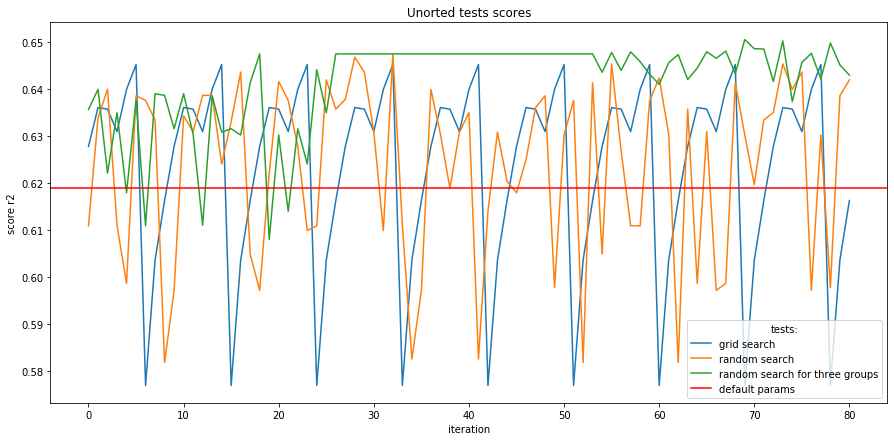

In [10]:
#comparison

name1='grid search'
data1=df.loc[df['experiment_name']==name1, ['iter_num','mean_test_score']].sort_values(by='iter_num').loc[:,'mean_test_score']

name2='random search'
data2=df.loc[df['experiment_name']==name2, ['iter_num','mean_test_score']].sort_values(by='iter_num').loc[:,'mean_test_score']

name3_1='random search for 1 group'
data3_1=df.loc[df['experiment_name']==name3_1, ['iter_num','mean_test_score']].sort_values(by='iter_num').loc[:,'mean_test_score']
name3_2='random search for 2 group'
data3_2=df.loc[df['experiment_name']==name3_2, ['iter_num','mean_test_score']].sort_values(by='iter_num').loc[:,'mean_test_score']
name3_3='random search for 3 group'
data3_3=df.loc[df['experiment_name']==name3_3, ['iter_num','mean_test_score']].sort_values(by='iter_num').loc[:,'mean_test_score']
name3='random search for three groups'
data3=pd.concat([data3_1,data3_2,data3_3])
name4='default params'
data4=df.loc[df['experiment_name']==name4, 'mean_test_score']

plt.figure(figsize=(15,7))
x=list(range(0, len(data1)))
plt.plot(x, data1, label=name1)
plt.plot(x, data2, label=name2)
plt.plot(x, data3, label=name3)
plt.axhline(data4.values, label=name4, color='r')
plt.legend(title='tests:')
plt.title("Unorted tests scores")
plt.ylabel("score r2")
plt.xlabel("iteration")
plt.savefig("graphs/2_2_scores.jpg")
plt.show()

In [11]:
best_scores=df.groupby(by='experiment_name')['mean_test_score'].max().reset_index()
print("best scores:")
print(best_scores)

best=pd.merge(df, best_scores, how='inner', on=['experiment_name','mean_test_score']).loc[:,['experiment_name','mean_test_score', 'params', 'iter_num']]
#best step and params

best scores:
             experiment_name  mean_test_score
0             default params         0.618922
1                grid search         0.645228
2              random search         0.647480
3  random search for 1 group         0.647480
4  random search for 2 group         0.647480
5  random search for 3 group         0.650531


In [16]:
best_iter=best.groupby('experiment_name')['iter_num'].min().reset_index()
params=pd.merge(df, best_iter, how='inner', on=['experiment_name','iter_num'])
print(params)
print(params.params.values)

             experiment_name  mean_fit_time  mean_score_time  mean_test_score  \
0                grid search       7.580407         0.031969         0.645228   
1              random search       6.298908         0.026304         0.647480   
2  random search for 1 group       6.120443         0.025746         0.647480   
3  random search for 2 group       6.227912         0.026176         0.647480   
4  random search for 3 group       5.414441         0.024647         0.650531   
5             default params       9.706070         0.044879         0.618922   

   param_alpha  param_colsample_bytree  param_gamma  param_lambda  \
0     0.250000                     NaN          NaN      0.250000   
1     0.575850                     NaN          NaN      0.783490   
2          NaN                     NaN          NaN           NaN   
3     0.244735                     NaN     0.095836      0.861544   
4          NaN                0.765828          NaN           NaN   
5          NaN    

In [13]:
params.loc[params['experiment_name']!='default params']

,experiment_name,mean_fit_time,mean_score_time,mean_test_score,param_alpha,param_colsample_bytree,param_gamma,param_lambda,param_max_depth,param_min_child_weight,...,rank_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,std_fit_time,std_score_time,std_test_score,iter_num
0,grid search,7.580407,0.031969,0.645228,0.250000,NaN,NaN,0.250000,5.0,6.0,...,1,0.667886,0.615705,0.591244,0.681695,0.669609,0.079762,0.000502,0.035280,6
1,random search,6.298908,0.026304,0.647480,0.575850,NaN,NaN,0.783490,4.0,5.0,...,1,0.644549,0.592139,0.623046,0.685618,0.692045,0.071182,0.000359,0.037706,33
2,random search for 1 group,6.120443,0.025746,0.647480,NaN,NaN,NaN,NaN,4.0,5.0,...,1,0.644549,0.592139,0.623046,0.685618,0.692045,0.039681,0.000465,0.037706,19
3,random search for 2 group,6.227912,0.026176,0.647480,0.244735,NaN,0.095836,0.861544,NaN,NaN,...,1,0.644549,0.592139,0.623046,0.685618,0.692045,0.158618,0.000809,0.037706,1
4,random search for 3 group,5.414441,0.024647,0.650531,NaN,0.765828,NaN,NaN,NaN,NaN,...,1,0.640012,0.615622,0.636650,0.681754,0.678616,0.081392,0.000304,0.025634,16


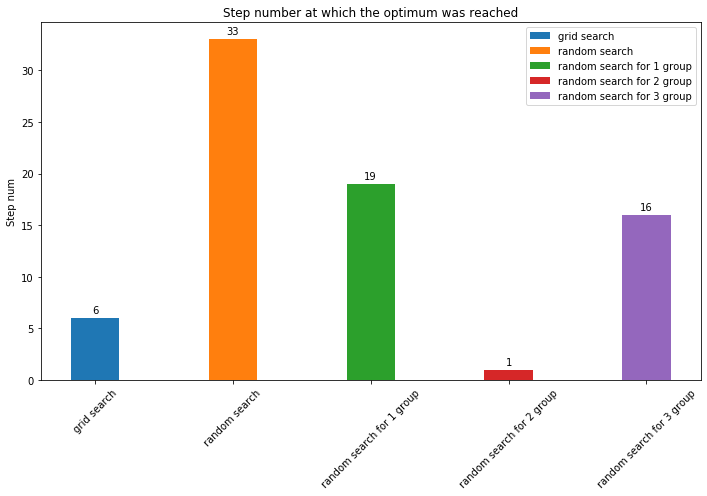

In [14]:
# on which min step algo get best result 
import math
params=params.loc[params['experiment_name']!='default params'].reset_index(drop=True)
x = np.arange(params.shape[0])  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10,7))

labels=params.loc[:,'experiment_name']
rects=[]
for row in range(params.shape[0]):
    rects.append(ax.bar(row, params.loc[row,'iter_num'], width, label=params.loc[row,'experiment_name']))
    autolabel(rects[row])

ax.set_ylabel('Step num')
ax.set_title('Step number at which the optimum was reached')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.legend()

fig.tight_layout()

plt.savefig("graphs/3_best_step.jpg")
plt.show()

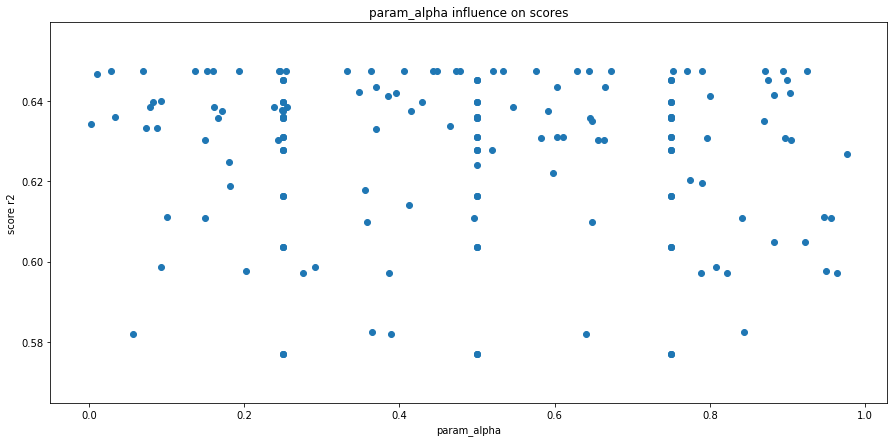

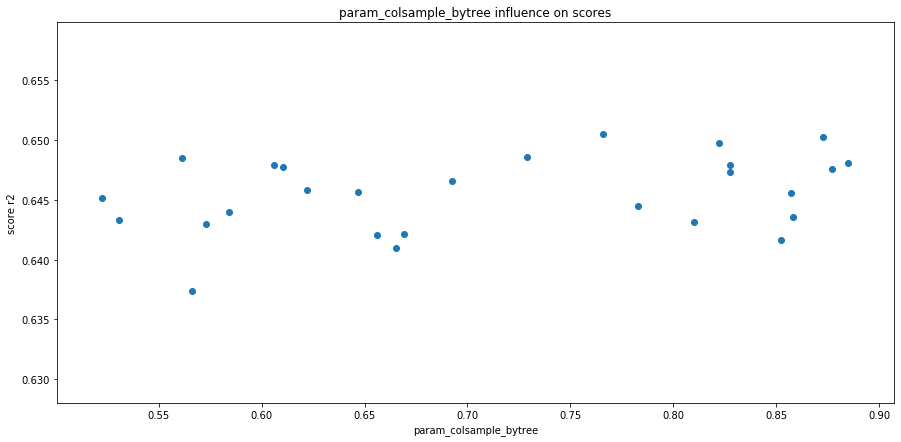

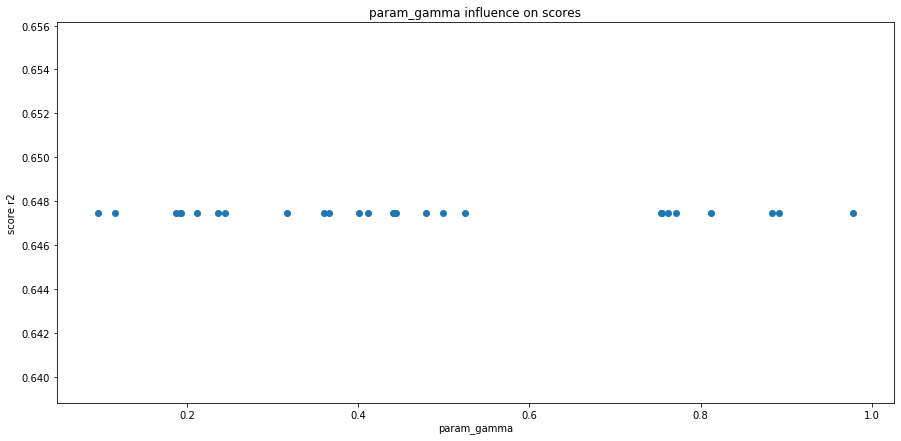

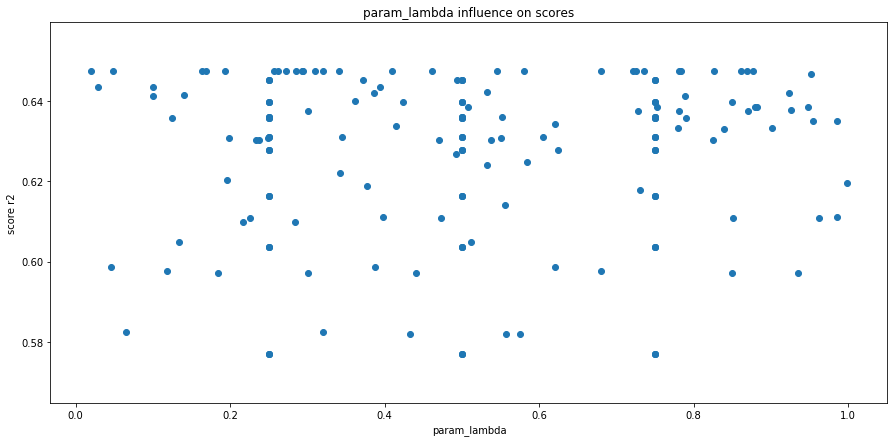

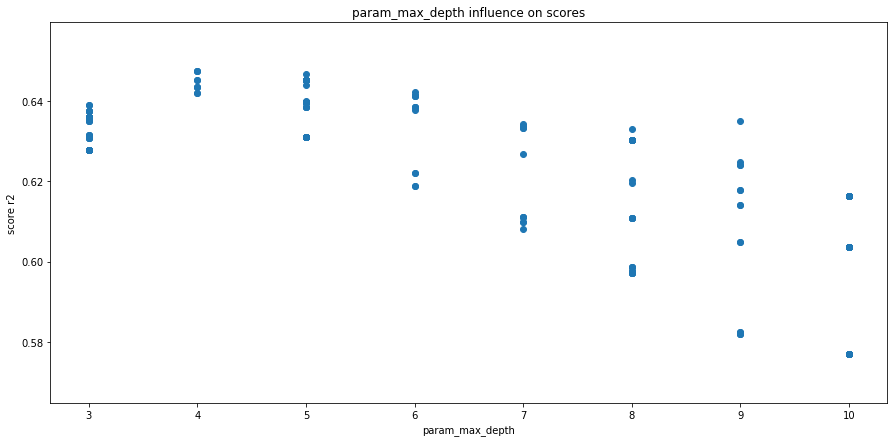

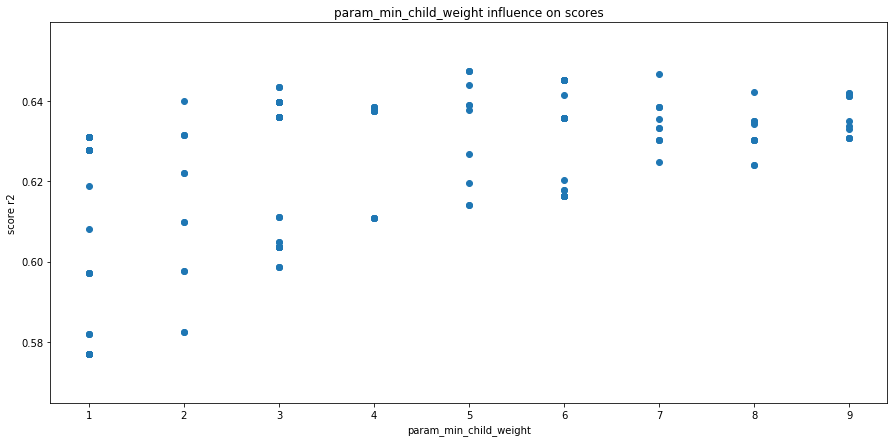

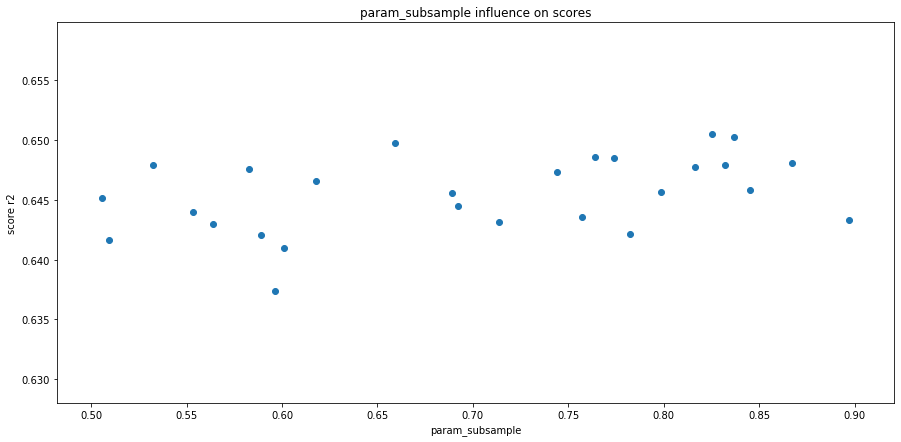

In [15]:
#params influence


params_list=['param_alpha', 'param_colsample_bytree',
       'param_gamma', 'param_lambda', 'param_max_depth',
       'param_min_child_weight', 'param_subsample']

for param in params_list:
    df.loc[:,param].unique().sort

    plt.figure(figsize=(15,7))
    x=df.loc[:,param]
    y=df.loc[:,'mean_test_score']
    plt.scatter(x, y)

    plt.title(param+" influence on scores")
    plt.xlabel(param)
    plt.ylabel("score r2")
    plt.savefig("graphs/4 {} influence.jpg".format(param))
    plt.show()